Size of the dataset: (146160, 9)
Shape of X_train: (116928, 8), Shape of X_test: (29232, 8), Shape of y_train: (116928,), Shape of y_test: (29232,)
Mean absolute Error: 3.6433932656102352


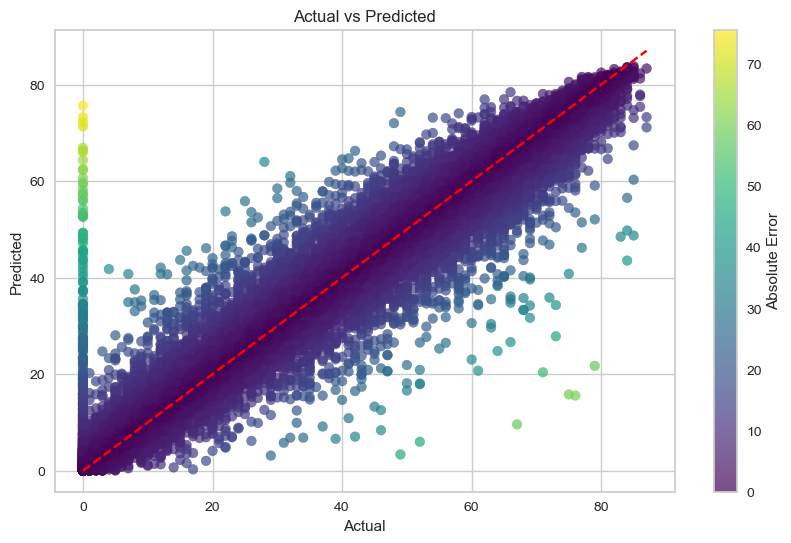

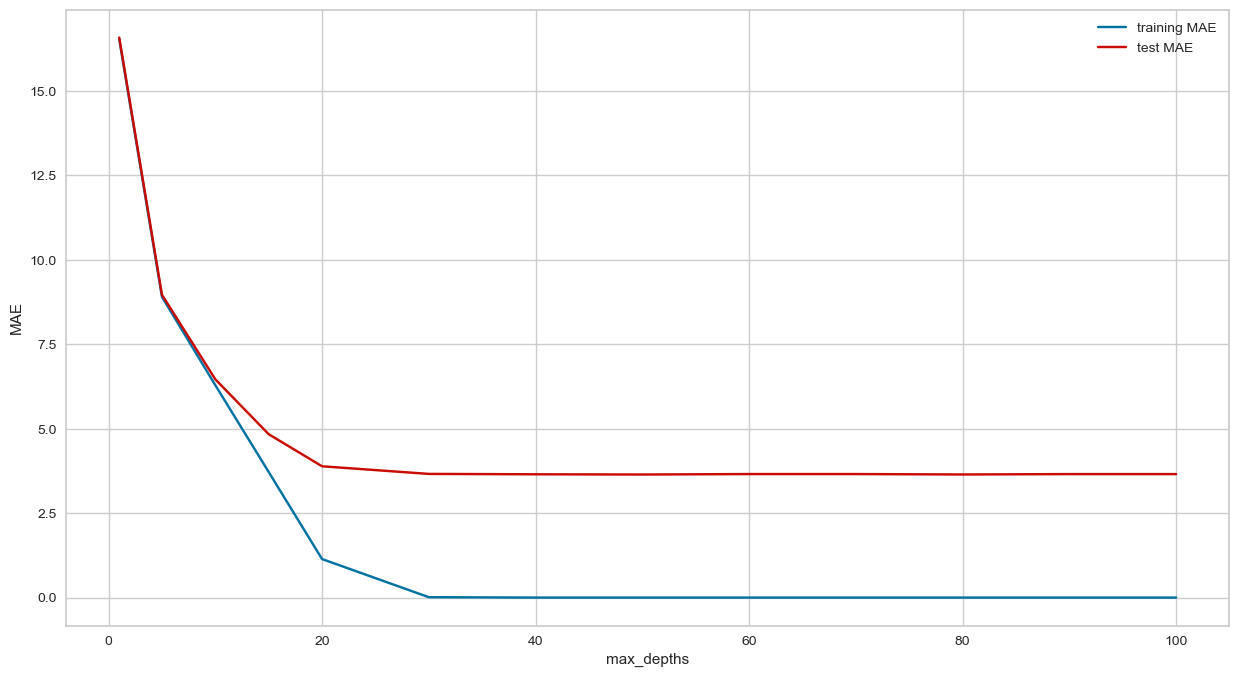

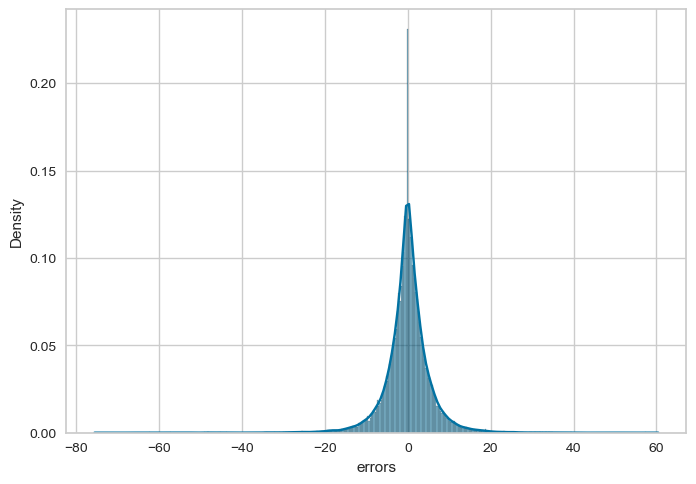

Density:

                   Count  Percentage
Underestimation   14724       50.37
Exact Estimation    333        1.14
Overestimation    14175       48.49


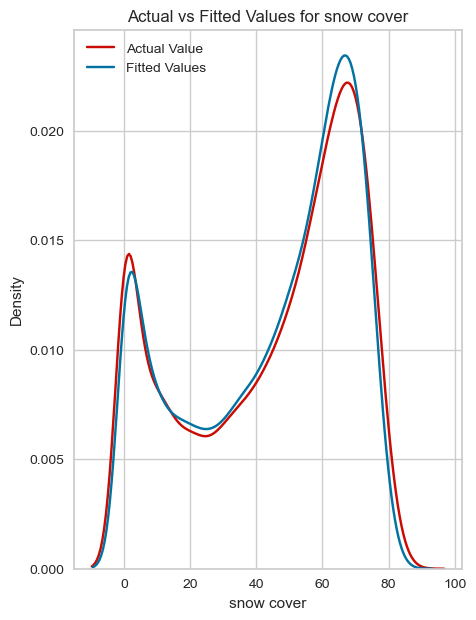

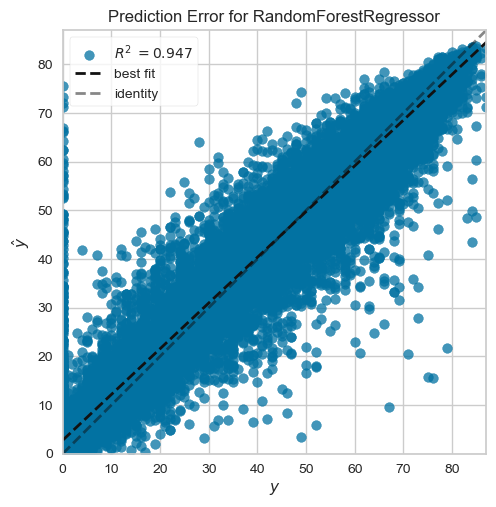

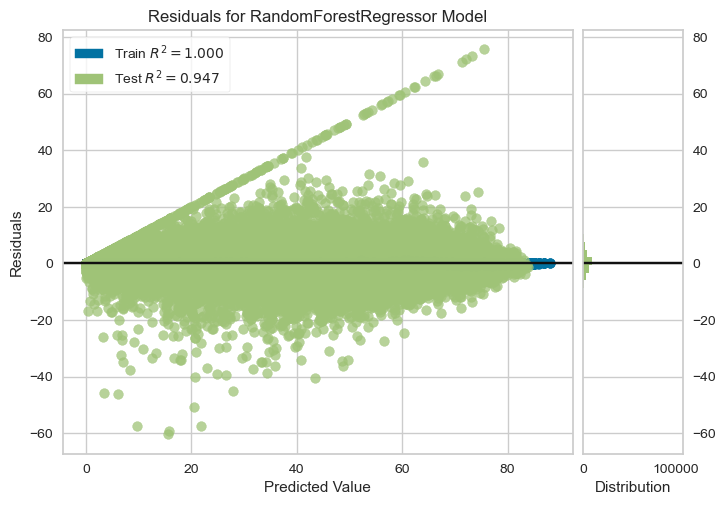

<Axes: title={'center': 'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [8]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, explained_variance_score, r2_score
from sklearn.inspection import permutation_importance

from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import ResidualsPlot

import shap
shap.initjs()

# Read the dataset
df = pd.read_csv ("D:\\GEE\\Zugspitze\\combined\\allmerged.csv")

# Rename columns x and y to longi and lati
df = df.rename(columns={'x': 'longi', 'y': 'lati'})

df.head(10)

print(f'Size of the dataset: {df.shape}')

# Input features
X = df.drop(['snow cover'], axis = 1)

# level features
y = df['snow cover']

# split the dataset into train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

print(f"Shape of X_train: {X_train.shape}, Shape of X_test: {X_test.shape}, Shape of y_train: {y_train.shape}, Shape of y_test: {y_test.shape}")

# Perform Min-Max scaling on X
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

RFrg = RandomForestRegressor(n_estimators = 200, min_samples_split = 2, 
                             min_samples_leaf= 1, max_features = 'log2', 
                             max_depth= 30, bootstrap=False,
                             n_jobs = -1, random_state=35)

RFrg = RFrg.fit(X_train, y_train)

y_pred = RFrg.predict(X_test)

# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean absolute Error: {mae}')

# Plot y_test vs y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, c=np.abs(y_test - y_pred), cmap='viridis', alpha=0.7)
plt.colorbar(label='Absolute Error')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.show()

# MAE
max_depths = [1,5,10,15,20,30,40,50,60,70,80,90,100]

# mean_absolute_erro
md_train_results = []
md_test_results = []

for max_depth in max_depths:
    # build the model
    rf = RandomForestRegressor (n_estimators = 200, min_samples_split = 2, 
                                min_samples_leaf= 1, max_features = 'log2', 
                                bootstrap=False, max_depth = max_depth, 
                                n_jobs = -1)
    rf.fit(X_train, y_train)
    
    # record training set expected error
    train_pred = rf.predict(X_train)
    md_train_results.append(mean_absolute_error(y_train, train_pred))
    
    # record test set expected error
    test_pred = rf.predict(X_test)
    md_test_results.append(mean_absolute_error(y_test, test_pred))

plt.figure(figsize = (15,8)) 
plt.plot(max_depths, md_train_results, 'b', label = 'training MAE')
plt.plot(max_depths, md_test_results, 'r', label = 'test MAE')
plt.xlabel('max_depths')
plt.ylabel('MAE')
plt.legend()
plt.show()

#Histplot
pf = pd.DataFrame({'actual': y_test, 'predicted': y_pred})
pf['errors'] = y_test - y_pred
sns.histplot(pf['errors'], kde = True, stat = 'density')
plt.show()

# Density
density = pd.DataFrame({'Count': [(pf['errors']<0).sum(), (pf['errors']==0).sum(),(pf['errors']>0).sum()]},
             columns=['Count'],
             index=['Underestimation', 'Exact Estimation', 'Overestimation'])
# Calculate percentages
total = density['Count'].sum()
density['Percentage'] = ((density['Count'] / total) * 100).round(2)

print("Density:\n",density)

#Density plot
plt.figure(figsize=(5, 7))
ax = sns.kdeplot(y_test, color="r", label="Actual Value")
sns.kdeplot(y_pred, color="b", label="Predicted Values" , ax=ax)
plt.legend()
plt.title('Actual vs Predicted Values for snow cover')
plt.show()

vl = PredictionError(RFrg)
vl.fit(X_train, y_train)
vl.score(X_test, y_test)
vl.poof()
plt.show()

rp = ResidualsPlot(RFrg)
rp.fit(X_train, y_train)
rp.score(X_test, y_test)
rp.poof()
plt.show()

#Shap values 
explainer = shap.TreeExplainer(RFrg)
shap_values = explainer.shap_values(X_test)

X_set = pd.DataFrame (X_test, columns = ['longi', 'lati', 'year', 'month', 'precipitation', 'temperature', 'windspeed',
       'elevation'])

#Summary plot
print("\n\nSHAP summary plot: Features importance")
shap.summary_plot(shap_values, X_set, plot_type="bar")
print("\n")
shap.summary_plot(shap_values, X_set)

#Decision Plot
print("\n\nSHAP decision plot")
shap.decision_plot(explainer.expected_value, shap_values[2,:], X_set.iloc[2])

#Force Plot
print("\n\nSHAP force plot")
shap.plots.force(explainer.expected_value, shap_values[2,:], X_set.iloc[2, :], matplotlib = True)

#Waterfall plot
print("\n\nSHAP waterfall plot")
shap.waterfall_plot(shap.Explanation(values=shap_values[2], 
                                              base_values=explainer.expected_value, data=X_set.iloc[2],  
                                         feature_names=X_set.columns.tolist()))
